In [78]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import seaborn as ssn
import matplotlib.patches as mpatches
import datadotworld as dw
import os
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float 
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from datetime import datetime, timedelta

In [2]:
#set up to reflect database
Base = automap_base()
engine = create_engine("sqlite:///hawaii.sqlite")
#reflect the database tables
Base.prepare(engine, reflect=True)
Station = Base.classes.station
Measurement = Base.classes.measurement
session = Session(engine)

In [3]:
user_start_date=input("When would you like to start your vaction?  Format YYYY-MM-DD ")
user_end_date=input("When would you like to end your vacation?  Format YYYY-MM-DD ")

When would you like to start your vaction?  Format MM-DD-YYYY 09-11-2018
When would you like to end your vacation?  Format MM-DD-YYYY 09-15-2018


## Precipitation Analysis

In [72]:
most_recent_date_query=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date=most_recent_date_query[0]
most_recent_date="2015-08-17"
most_recent_date_split=most_recent_date.split("-")
year_before=str(int(most_recent_date_split[0])-1)
one_year_earlier = year_before+'-'+most_recent_date_split[1]+'-'+most_recent_date_split[2]
print(one_year_earlier)

2014-08-17


In [5]:
precip_query=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_earlier).order_by(Measurement.date).all()

In [6]:
precip_df = pd.DataFrame(precip_query, columns=["date","prcp"]) 
precip_df=precip_df.set_index("date")

In [7]:
precip_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.00
2016-08-23,0.02


In [8]:
precip_df.describe()

,prcp
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


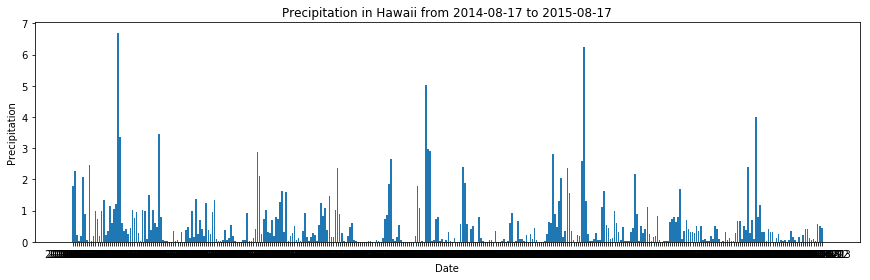

In [82]:
plt.figure(figsize=(12,4))
plt.bar(precip_df.index, precip_df['prcp'])
plt.title(("Precipitation in Hawaii from %s to %s") % (one_year_earlier, most_recent_date))
plt.xlabel("Date")
plt.tight_layout()
plt.ylabel("Precipitation")
plt.savefig("hawaii_prcipitation_graph.png")
plt.show()

In [10]:
number_of_stations = session.query(Station.station_id).count()
print("There are " + str(number_of_stations) +" stations in Hawaii.")

There are 9 stations in Hawaii.


In [102]:
stations=session.query(Station.station, Station.name).group_by(Station.name).all()
station_dict=dict(stations)
print(stations[:])

[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'), ('USC00513117', 'KANEOHE 838.1, HI US'), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US'), ('USC00517948', 'PEARL CITY, HI US'), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'), ('USC00519281', 'WAIHEE 837.5, HI US'), ('USC00519397', 'WAIKIKI 717.2, HI US'), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')]


In [35]:
from sqlalchemy import func
station_info=session.query(Measurement.station, func.count(Measurement.measurement_id)).group_by(Measurement.station).all()

sorted_list=sorted(station_info, key=lambda x: x[1], reverse=True)
for item in sorted_list:
    print(item[0], station_dict[item[0]], item[1])

USC00519281 WAIHEE 837.5, HI US 2772
USC00519397 WAIKIKI 717.2, HI US 2724
USC00513117 KANEOHE 838.1, HI US 2709
USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 2669
USC00516128 MANOA LYON ARBO 785.2, HI US 2612
USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 2202
USC00511918 HONOLULU OBSERVATORY 702.2, HI US 1979
USC00517948 PEARL CITY, HI US 1372
USC00518838 UPPER WAHIAWA 874.3, HI US 511


In [39]:
print("The station with the highest number of observations is:")
print(sorted_list[0][0], station_dict[sorted_list[0][0]], sorted_list[0][1])

The station with the highest number of observations is:
USC00519281 WAIHEE 837.5, HI US 2772


In [48]:
twelve_months = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >=one_year_earlier)\
.filter(Measurement.station==sorted_list[0][0]).all()


In [51]:
x_values=[]
for item in twelve_months:
    x_values.append(item[1])

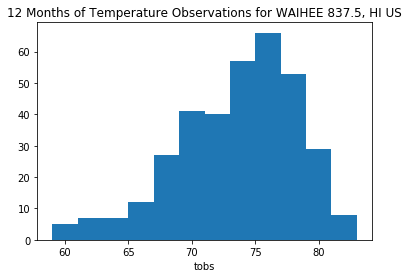

In [58]:
plt.hist(x_values, 12)
plt.title("12 Months of Temperature Observations for %s" % station_dict[sorted_list[0][0]])
plt.xlabel("tobs")
plt.savefig("histogram_of_tobs.png")
plt.show()

## Temperature Analysis

In [73]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)
def year_before(date):
    date_split=date.split("-")
    year_before=str(int(date_split[0])-1)
    one_year_earlier = year_before+'-'+date_split[1]+'-'+date_split[2]
    return one_year_earlier

In [83]:
user_start_date=input("When would you like to start your vaction?  Format YYYY-MM-DD ")
user_end_date=input("When would you like to end your vacation?  Format YYYY-MM-DD ")

When would you like to start your vaction?  Format YYYY-MM-DD 2018-06-03
When would you like to end your vacation?  Format YYYY-MM-DD 2018-06-11


In [75]:
#start_date="2016-09-22"
#end_date="2016-09-27"
def calc_temps(desired_start_date, desired_end_date):
    start_date=year_before(desired_start_date)
    end_date=year_before(desired_end_date)
    vacay_list = session.query(Measurement.tobs, Measurement.date).filter(Measurement.date>=start_date)\
        .filter(Measurement.date<=end_date).all()
    vacay_temps_list = []
    for item in vacay_list:
        vacay_temps_list.append(item[0])
    minimumn_temp = min(vacay_temps_list)
    maximum_temp = max(vacay_temps_list)
    average_temp = mean(vacay_temps_list)
    return minimumn_temp, maximum_temp, average_temp

In [84]:
trip_min_temp, trip_max_temp, trip_avg_temp = calc_temps(user_start_date, user_end_date)
print("The minimum temperature is: %s" % str(trip_min_temp))
print("The maximum temperature is: %s" % str(trip_max_temp))
print("The average temperature is: %s" % str(trip_avg_temp))

The minimum temperature is: 72
The maximum temperature is: 81
The average temperature is: 77.36206896551724


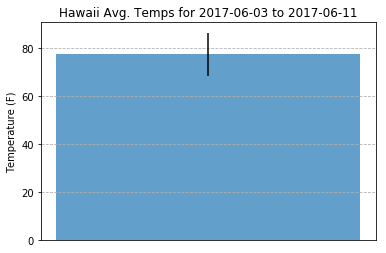

In [96]:
x_value=[1]
plt.bar(x_value, trip_avg_temp, alpha=0.7, yerr=trip_max_temp-trip_min_temp, width=.5)
plt.title("Hawaii Avg. Temps for %s to %s" % (year_before(user_start_date), year_before(user_end_date)))
plt.ylabel("Temperature (F)")
plt.grid(axis="y", linestyle="dashed")
plt.tick_params(axis='x', bottom='off',labelbottom='off')
plt.savefig("Hawaii_avg_temps.png")
plt.show()